# Radial Beam Sampling

In [156]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import math
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

### Load the dataset

In [157]:
dataset_name = 'siscore/rotation'
dataset = tfds.load(dataset_name, split='test', shuffle_files=True)

image_size = 512
n_beams = 512

### Radial Cropping images

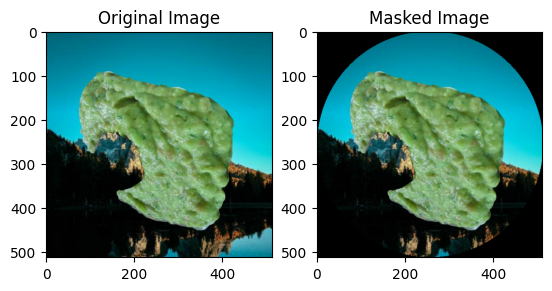

In [158]:
def create_circular_mask(height, width, center=None, radius=None):
    if center is None:
        center = [height // 2, width // 2]
    if radius is None:
        radius = min(center[0], center[1], height - center[0], width - center[1])

    y, x = np.ogrid[:height, :width]
    mask = (x - center[1]) ** 2 + (y - center[0]) ** 2 <= radius ** 2
    return mask.astype(np.float32)

def apply_circular_mask(image):

    center = [image.shape[0] // 2, image.shape[1] // 2]
    radius = min(center[0], center[1])

    height, width, _ = image.shape

    mask = create_circular_mask(height, width, center, radius)
    mask = np.expand_dims(mask, axis=-1)

    masked_image = image * mask

    return tf.convert_to_tensor(masked_image, dtype=tf.float32)


image = next(iter(dataset))['image']
image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
masked_image = apply_circular_mask(image)

plt.subplot(1, 2, 1)
plt.imshow(image.numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(masked_image.numpy())
plt.title("Masked Image")

plt.show()

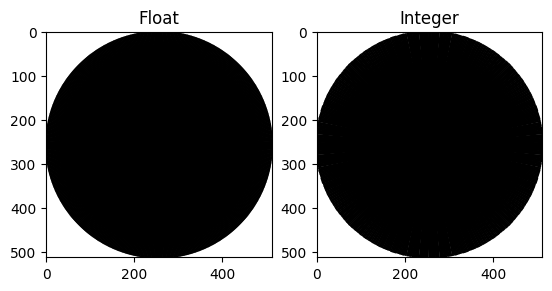

In [159]:
def get_endpoints(radius: int, num_points: int) -> np.ndarray:
    k = np.arange(num_points)
    x = radius * np.cos(2 * k * np.pi / num_points)
    y = radius * np.sin(2 * k * np.pi / num_points)
    return np.stack([x, y], axis=-1) + radius

fig, axs = plt.subplots(1,2)
bg_image = np.ones((image_size, image_size, 3), dtype=np.uint8) * 255

center = np.array([image_size // 2, image_size // 2])
endpoints = get_endpoints(image_size // 2, n_beams)
for endpoint in endpoints:
    endpoint = np.array(endpoint)
    axs[0].plot([center[0], endpoint[0]], [center[1], endpoint[1]], color='black')
axs[0].set_title('Float')
axs[0].imshow(bg_image)
# axs[0].axis('off')

center = center.astype(np.int32)
endpoints = endpoints.astype(np.int32)
for endpoint in endpoints:
    endpoint = np.array(endpoint)
    axs[1].plot([center[0], endpoint[0]], [center[1], endpoint[1]], color='black')
axs[1].set_title('Integer')
axs[1].imshow(bg_image)
# axs[1].axis('off')

plt.show()

### Bresenham to estimate pixel positions

In [160]:
def bresenham(start, end, length=None):
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points, left, right = [], [], []
    for x in range(x1, x2 + 1):
        coord = [y, x] if is_steep else [x, y]
        points.append(coord)
        proxy_a = [coord[0] - 1, coord[1]] if is_steep else [coord[0], coord[1] - 1]
        proxy_b = [coord[0] + 1, coord[1]] if is_steep else [coord[0], coord[1] + 1]
        if swapped or is_steep:
            left.append(proxy_b)
            right.append(proxy_a)
        # elif not swapped and is_steep:
        #     left.append(proxy_b)
        #     right.append(proxy_a)
        else:
            left.append(proxy_a)
            right.append(proxy_b)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
        left.reverse()
        right.reverse()
    if length is not None:
        return np.array(left)[:length], np.array(points)[:length], np.array(right)[:length]
    return np.array(left), np.array(points), np.array(right)

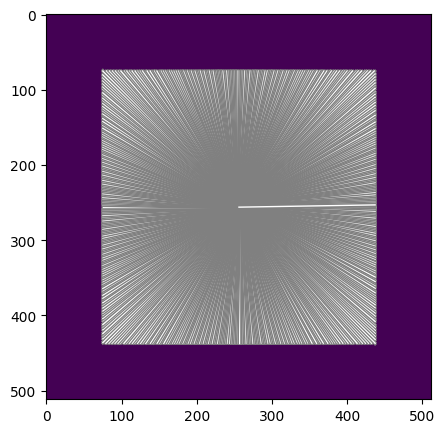

In [161]:
lines = [bresenham(center, endpoint, length=None) for endpoint in endpoints]
# clip by shortest beam
shortest_length = np.min([len(point_set) for line in lines for point_set in line])
lines = tf.cast([[point_set[:shortest_length] for point_set in line] for line in lines], tf.int32)
# lines = tf.clip_by_value(lines, 0, image_size//2 - 1)
# print(lines.shape)

bg_image = np.zeros((image_size, image_size, 1))
fig = plt.figure(figsize=(5, 5))
for line in lines:
    left, beam, right = line
    plt.plot([left[0, 0], left[-1, 0]], [left[0, 1], left[-1, 1]],
            color="gray", linewidth=2)
    plt.plot([right[0, 0], right[-1, 0]], [right[0, 1], right[-1, 1]],
            color="gray", linewidth=2)
    plt.plot([beam[0, 0], beam[-1, 0]], [beam[0, 1], beam[-1, 1]],
            color="white", linewidth=1)
    # plt.plot([line[0, 0, 0], line[0, -1, 0]], [line[0, 0, 1], line[0, -1, 1]],
    #         color="white", linewidth=1, linestyle='dashed')
    # plt.plot([line[2, 0, 0], line[2, -1, 0]], [line[2, 0, 1], line[2, -1, 1]],
    #         color="white", linewidth=1, linestyle='dashed')
plt.imshow(bg_image)

### sample radial beams from images in dataset

tf.Tensor(0.0, shape=(), dtype=float64) tf.Tensor(511.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64) tf.Tensor(511.0, shape=(), dtype=float64)


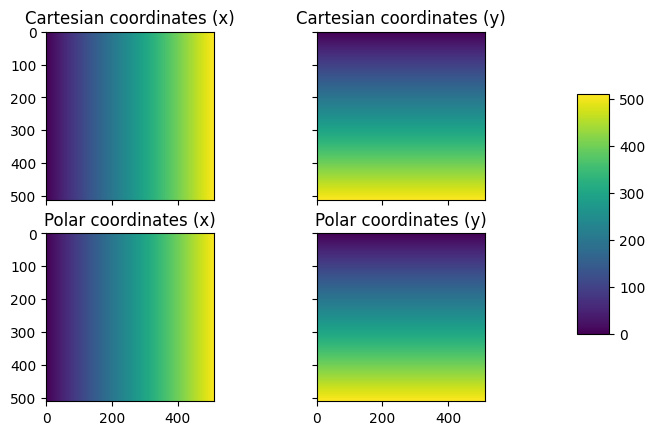

In [162]:
def cartesian_to_polar_grid(image_grid):
    """ Computes the angle of each pixel vector w.r.t. the center of the image.
    Therefore, the image_grid is assumed to be [-image_size/2, image_size/2].
    """
    x = image_grid[..., 0]
    y = image_grid[..., 1]
    
    theta = tf.atan2(y, x)
    # theta = (theta - tf.reduce_min(theta)) / (tf.reduce_max(theta) - tf.reduce_min(theta))
    # theta *= image_size-1
    # print(tf.reduce_min(theta), tf.reduce_max(theta))

    r = tf.sqrt(x**2 + y**2)
    # r = (r - tf.reduce_min(r)) / (tf.reduce_max(r) - tf.reduce_min(r))
    # r *= image_size-1
    # print(tf.reduce_min(r), tf.reduce_max(r))
    x = r * tf.cos(theta) + image_size/2
    y = r * tf.sin(theta) + image_size/2
    
    x = tf.clip_by_value(x, 0, image_size-1)
    y = tf.clip_by_value(y, 0, image_size-1)
    print(tf.reduce_min(x), tf.reduce_max(x))
    print(tf.reduce_min(y), tf.reduce_max(y))

    polar_coordinates = tf.stack([x, y], axis=-1)
    return tf.cast(polar_coordinates, tf.int32)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

# x, y = np.meshgrid(np.linspace(0, 1, image_size), np.linspace(0, 1, image_size), indexing='ij')
x, y = np.meshgrid(np.linspace(-image_size/2, image_size/2, image_size),
                   np.linspace(-image_size/2, image_size/2, image_size))
cartesian = np.stack([x, y], axis=-1)
axs[0, 0].imshow(cartesian[..., 0])
axs[0, 0].set_title('Cartesian coordinates (x)')
im = axs[0, 1].imshow(cartesian[..., 1])
axs[0, 1].set_title('Cartesian coordinates (y)')

polar = cartesian_to_polar_grid(cartesian)
axs[1, 0].imshow(polar.numpy()[..., 0])
axs[1, 0].set_title('Polar coordinates (x)')
im = axs[1, 1].imshow(polar.numpy()[..., 1])
axs[1, 1].set_title('Polar coordinates (y)')
fig.colorbar(im, cax=fig.add_axes([1., 0.25, 0.05, 0.5]), orientation='vertical')

plt.show()

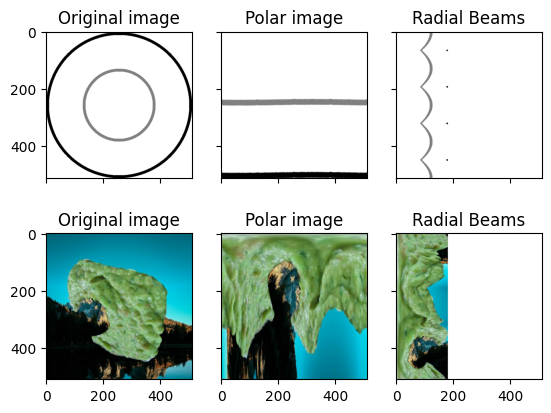

In [163]:
def make_grid(h, w):
    X, Y = tf.meshgrid(tf.linspace(-1., 1., h), tf.linspace(-1., 1., w))
    X = tf.reshape(X, (1, -1))
    Y = tf.reshape(Y, (1, -1))
    grid = tf.concat([X, Y], axis=0)
    return grid

def get_pixel_value(im, x, y):
    b, h, w, c = im.shape 
    x, y = tf.cast(x, 'int32'), tf.cast(y, 'int32')
    batch_idx = tf.range(0, b) [:, None, None]
    b = tf.tile(batch_idx, (1, h, w))
    indices = tf.stack([b, y, x], -1)
    return tf.gather_nd(im, indices)

def interpolate(im, x, y):
    b, h, w, c = im.shape
    max_y, max_x = h-1., w-1.
    
    #finds neighbors
    x = 0.5 * ((x+1.) * max_x)
    y = 0.5 * ((y+1.) * max_y)
    x0, y0 = tf.floor(x), tf.floor(y)
    x1, y1 = x0 + 1., y0 + 1.
    x0, y0 = tf.clip_by_value(x0, 0., max_x), tf.clip_by_value(y0, 0., max_y)
    x1, y1 = tf.clip_by_value(x1, 0., max_x), tf.clip_by_value(y1, 0., max_y)
    
    #get neighbor pixels
    Ia = get_pixel_value(im, x0, y0)
    Ib = get_pixel_value(im, x0, y1)
    Ic = get_pixel_value(im, x1, y0)
    Id = get_pixel_value(im, x1, y1)
    
    #calculate distance to neighbors
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    #weighted sum over neighbors
    I = wa[..., None] * Ia + wb[..., None] * Ib + wc[..., None] * Ic + wd[..., None] * Id
    return I

def log_polar_transform(x, radius_factor = tf.sqrt(2.)):
    '''rho(x) ,theta(y): [-1, 1]
    theta : [-1 * pi + pi, 1 * pi + pi] = [0, 2pi]
    rho: [log(-1 * h/2 + h/2), log(1 * h/2 + h/2)] --> [1, logh] 
    r: exp(rho)-1 -->[0, h-1] 
    r: normalize --> r/(h-1) -->[0, 1]
    x = e^rho * cos(theta)
    y = e^rho & sin(theta)
    '''
    b, h, w, c = x.shape
    grid = make_grid(h, w) #(2, hw), represent log-polar coordinate system
    grid = tf.repeat(grid[None, ...], b, axis=0) #(b, 2, hw) 
    X, Y = grid[:, 0], grid[:, 1]
    
    #theta 
    theta = (Y + 1) * math.pi #[0, 2pi]
    
    #radius
    maxR = max(h, w) * radius_factor
    r = tf.exp((X + 1)/2 * tf.math.log(maxR)) #[1, h]
    r = (r-1)/(maxR -1) #[0, h]-->[0, 1]
    r = r * (maxR/h) #scale factorize
    
    #map to cartesian coordinate system
    xs = tf.reshape(r * tf.math.cos(theta), [b, h, w])
    ys = tf.reshape(r * tf.math.sin(theta), [b, h, w])
    output = interpolate(x, xs, ys)
    output = tf.reshape(output, [b, h, w, c])
    return output

def polar_transform(x, radius_factor=tf.sqrt(2.)):
    '''Polar coordinate transformation: (r, theta)
    r: [0, 1]
    theta: [0, 2pi]
    x = r * cos(theta)
    y = r * sin(theta)
    '''
    b, h, w, c = x.shape
    grid = make_grid(h, w)  # Assuming make_grid function generates a grid
    grid = tf.repeat(grid[None, ...], b, axis=0)  # (b, 2, hw)

    # Theta
    theta = (grid[:, 0] + 1) * math.pi  # [0, 2pi]

    # Radius
    r = grid[:, 1] * 0.5 + 0.5  # [0, 1]

    # Map to Cartesian coordinate system
    xs = tf.reshape(r * tf.math.cos(theta), [b, h, w])
    ys = tf.reshape(r * tf.math.sin(theta), [b, h, w])
    
    # Interpolate
    output = interpolate(x, xs, ys)
    output = tf.reshape(output, [b, h, w, c])
    return output

def inverse_log_polar_transform(x):
    b, h, w, c = x.shape
    grid = make_grid(h, w) #(2, hw), represent log-polar coordinate system
    grid = tf.repeat(grid[None, ...], b, axis=0) #(b, 2, hw) 
    X, Y = grid[:, 0], grid[:, 1]
    
    rs = tf.sqrt(X**2 + Y **2)/tf.sqrt(2.)
    ts = (tf.atan2(-Y, -X))/math.pi #[-1., 1.]
    
    rs = tf.reshape(rs, [b, h, w])
    ts = tf.reshape(ts, [b, h, w])
    output = interpolate(x, rs, ts)
    output = tf.reshape(output, [b, h, w, c])
    return output

def inverse_polar_transform(polar_image):
    '''Inverse Polar coordinate transformation: (r, theta) to Cartesian (x, y)
    r: [0, 1]
    theta: [0, 2pi]
    x = r * cos(theta)
    y = r * sin(theta)
    '''
    b, h, w, c = polar_image.shape
    grid = make_grid(h, w)  # Assuming make_grid function generates a grid
    grid = tf.repeat(grid[None, ...], b, axis=0)  # (b, 2, hw)

    # Calculate Cartesian coordinates from polar coordinates
    theta = (grid[:, 0] + 1) * math.pi  # [0, 2pi]
    r = grid[:, 1] * 0.5 + 0.5  # [0, 1]

    # Map to Cartesian coordinate system
    xs = tf.reshape(r * tf.math.cos(theta), [b, h, w])
    ys = tf.reshape(r * tf.math.sin(theta), [b, h, w])

    # Interpolate
    cartesian_image = interpolate(polar_image, xs, ys)
    cartesian_image = tf.reshape(cartesian_image, [b, h, w, c])
    return cartesian_image

def create_circle_matrix(height, width, radius, thickness):
    matrix = np.ones((height, width, 1))
    y, x = np.ogrid[:height, :width]

    # Equation of a circle centered at (h/2, w/2) with specified radius and thickness
    circle_mask = ((x - width / 2)**2 + (y - height / 2)**2 <= (radius)**2) & \
                  ((x - width / 2)**2 + (y - height / 2)**2 >= (radius - thickness)**2)

    # Set the values inside the circle to 0 (black)
    matrix[circle_mask] = 0
    
    # Equation of a circle centered at (h/2, w/2) with specified radius and thickness
    circle_mask = ((x - width / 2)**2 + (y - height / 2)**2 <= (radius/2)**2) & \
                  ((x - width / 2)**2 + (y - height / 2)**2 >= (radius/2 - thickness)**2)

    # Set the values inside the circle to 0 (black)
    matrix[circle_mask] = 0.5
    return matrix

test_image = create_circle_matrix(image_size, image_size, image_size/2, 10)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

axs[0, 0].imshow(test_image, cmap=plt.cm.gray)
axs[0, 0].set_title('Original image')
# from skimage.transform import warp_polar
# axs[0, 1].imshow(warp_polar(test_image, channel_axis=-1), cmap=plt.cm.gray)
axs[0, 1].imshow(polar_transform(tf.cast(test_image[None], tf.float32))[0], cmap=plt.cm.gray)
axs[0, 1].set_title('Polar image')
axs[0, 2].imshow(tf.concat([tf.cast(tf.gather_nd(test_image, lines)[:, 1], float), 
                            tf.ones((n_beams, n_beams - lines.shape[2], 1))], axis=1), cmap=plt.cm.gray)
axs[0, 2].set_title('Radial Beams')

axs[1, 0].imshow(image)
axs[1, 0].set_title('Original image')
axs[1, 1].imshow(polar_transform(tf.cast(image[None], tf.float32))[0])
axs[1, 1].set_title('Polar image')
axs[1, 2].imshow(tf.concat([tf.cast(tf.gather_nd(image, lines)[:, 1], float), 
                            tf.ones((n_beams, n_beams - lines.shape[2], 3))], axis=1), cmap=plt.cm.gray)
axs[1, 2].set_title('Radial Beams')
# todo increase beam size such that full image 512 is shown
plt.show()

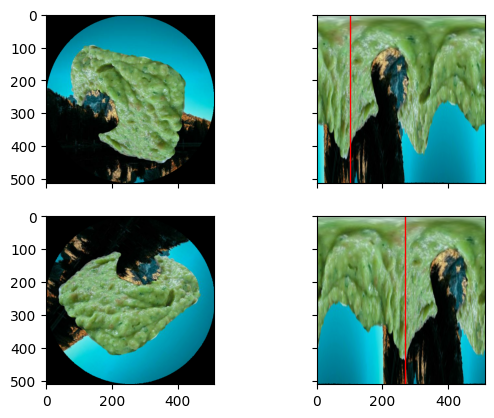

In [251]:
fig, axs = plt.subplots(2,2,sharex=True, sharey=True)

rot_image = tfa.image.rotate(masked_image, 180.)
rot_image = tf.cast(rot_image, tf.float32)

axs[0, 0].imshow(masked_image)
axs[1, 0].imshow(rot_image)

polar = polar_transform(masked_image[None])[0]
rot_polar = polar_transform(rot_image[None])[0]

axs[0, 1].imshow(polar)
axs[1, 1].imshow(rot_polar)

axs[0, 1].axvline(100, color='r', linewidth=1)
axs[1, 1].axvline(100+(512//4)+40, color='r', linewidth=1)

plt.show()

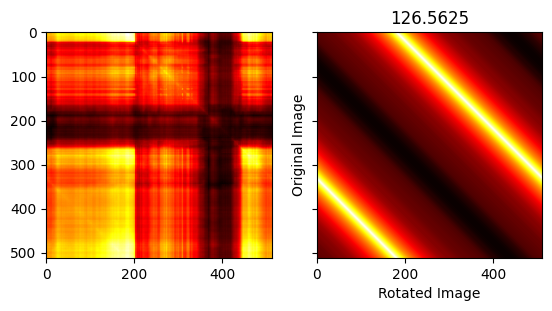

In [252]:
def toeplitz_extractor(n_vectors: int) -> tf.Tensor:
    return tf.cast(
        [tf.roll(tf.eye(n_vectors), shift=i, axis=0) for i in tf.range(n_vectors)],
        tf.float32)

# dot product over W
# [C x H x W] * [C x W x H] = [C x H x H]
dot = tf.transpose(polar, (2, 1, 0)) @ tf.transpose(rot_polar, (2, 0, 1))
# average over [C] -> [H x H]
dot = tf.reduce_mean(dot, axis=0)

fig, axs = plt.subplots(1,2,sharex=True, sharey=True)
axs[0].imshow(dot, cmap='hot', interpolation='nearest')

toeplitz_matrices = toeplitz_extractor(n_beams)
diag_score = tf.reduce_sum(toeplitz_matrices * dot[None], axis=(-1, -2), keepdims=True)
toeplitz_matrices *= diag_score
toeplitz = tf.reduce_sum(toeplitz_matrices, axis=0)
axs[1].imshow(toeplitz, cmap='hot')

n = 512 - tf.math.argmax(diag_score).numpy()[0, 0]
plt.title((n/512) * 360)
plt.xlabel('Rotated Image')
plt.ylabel('Original Image')
plt.show()